In [ ]:
!pip install torch torchvision matplotlib numpy pillow torchsummary tensorboard

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import numpy as np
import os
from PIL import Image
import math
from torch.utils.tensorboard import SummaryWriter
import datetime
from torchsummary import summary
from torchvision.models.resnet import BasicBlock


In [46]:
print(torch.__version__)
print(torch.cuda.is_available())

2.5.1+cu124
True


In [47]:
# Configuración del dispositivo (GPU si está disponible)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(device)

cuda


In [49]:
# Definir las transformaciones para los conjuntos de datos de entrenamiento y validación
data_transforms = {
    'train': transforms.Compose([
        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
    'val': transforms.Compose([
        transforms.Resize(256),
        transforms.CenterCrop(224),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}


In [50]:
# Definir las rutas a los directorios de datos
data_dir = 'datasets/train'
val_dir = 'datasets/val'
# Define el porcentaje de datos a utilizar (por ejemplo, 50%)
portion_train = 1
portion_val = 1

# Cargar los conjuntos de datos de entrenamiento y validación
full_train_dataset = datasets.ImageFolder(data_dir, data_transforms['train'])
full_val_dataset = datasets.ImageFolder(val_dir, data_transforms['val'])

# Calcular el número de muestras a usar según el porcentaje
num_train_samples = int(len(full_train_dataset) * portion_train)
num_val_samples = int(len(full_val_dataset) * portion_val)

# Crear un subset de los datos
train_indices = torch.randperm(len(full_train_dataset)).tolist()[:num_train_samples]
val_indices = torch.randperm(len(full_val_dataset)).tolist()[:num_val_samples]

image_datasets = {
    'train': torch.utils.data.Subset(full_train_dataset, train_indices),
    'val': torch.utils.data.Subset(full_val_dataset, val_indices)
}

# Crear DataLoaders
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=32, shuffle=True, num_workers=4),
    'val': DataLoader(image_datasets['val'], batch_size=32, shuffle=False, num_workers=4)
}

# Obtener las clases
class_names = full_train_dataset.classes

# Obtener el tamaño de los conjuntos de datos
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}

In [51]:
# Cargar un modelo pre-entrenado (ResNet18) y ajustar las últimas capas
model = models.resnet18(pretrained=True)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, len(class_names))
model = model.to(device)

In [52]:
# Definir la función de pérdida y el optimizador
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

In [53]:
# Función para entrenar el modelo
def train_model(model, criterion, optimizer, num_epochs=5):
    best_model_wts = model.state_dict()
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch + 1}/{num_epochs}')
        print('-' * 10)

        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_corrects = 0

            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
            
            # Registrar la pérdida y precisión en TensorBoard
            writer.add_scalar(f'{phase} Loss', epoch_loss, epoch)
            writer.add_scalar(f'{phase} Accuracy', epoch_acc, epoch)

            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = model.state_dict()

        print()

    model.load_state_dict(best_model_wts)
    return model

In [54]:
# Entrenar el modelo
model = train_model(model, criterion, optimizer, num_epochs=5)
# Guardar el modelo entrenado
torch.save(model.state_dict(), 'model.pth')

Epoch 1/5
----------
train Loss: 0.6426 Acc: 0.6025
val Loss: 0.4168 Acc: 0.9020

Epoch 2/5
----------
train Loss: 0.4427 Acc: 0.8115
val Loss: 0.2667 Acc: 0.9346

Epoch 3/5
----------
train Loss: 0.3174 Acc: 0.8934
val Loss: 0.1967 Acc: 0.9412

Epoch 4/5
----------
train Loss: 0.2345 Acc: 0.8934
val Loss: 0.1697 Acc: 0.9477

Epoch 5/5
----------
train Loss: 0.2128 Acc: 0.9180
val Loss: 0.1578 Acc: 0.9477



In [56]:
# Función para predecir una imagen
def predict_image(image_path):
    model.eval()
    image = Image.open(image_path)
    image = data_transforms['val'](image).unsqueeze(0)
    image = image.to(device)

    with torch.no_grad():
        outputs = model(image)
        _, preds = torch.max(outputs, 1)
    
    return class_names[preds[0]]

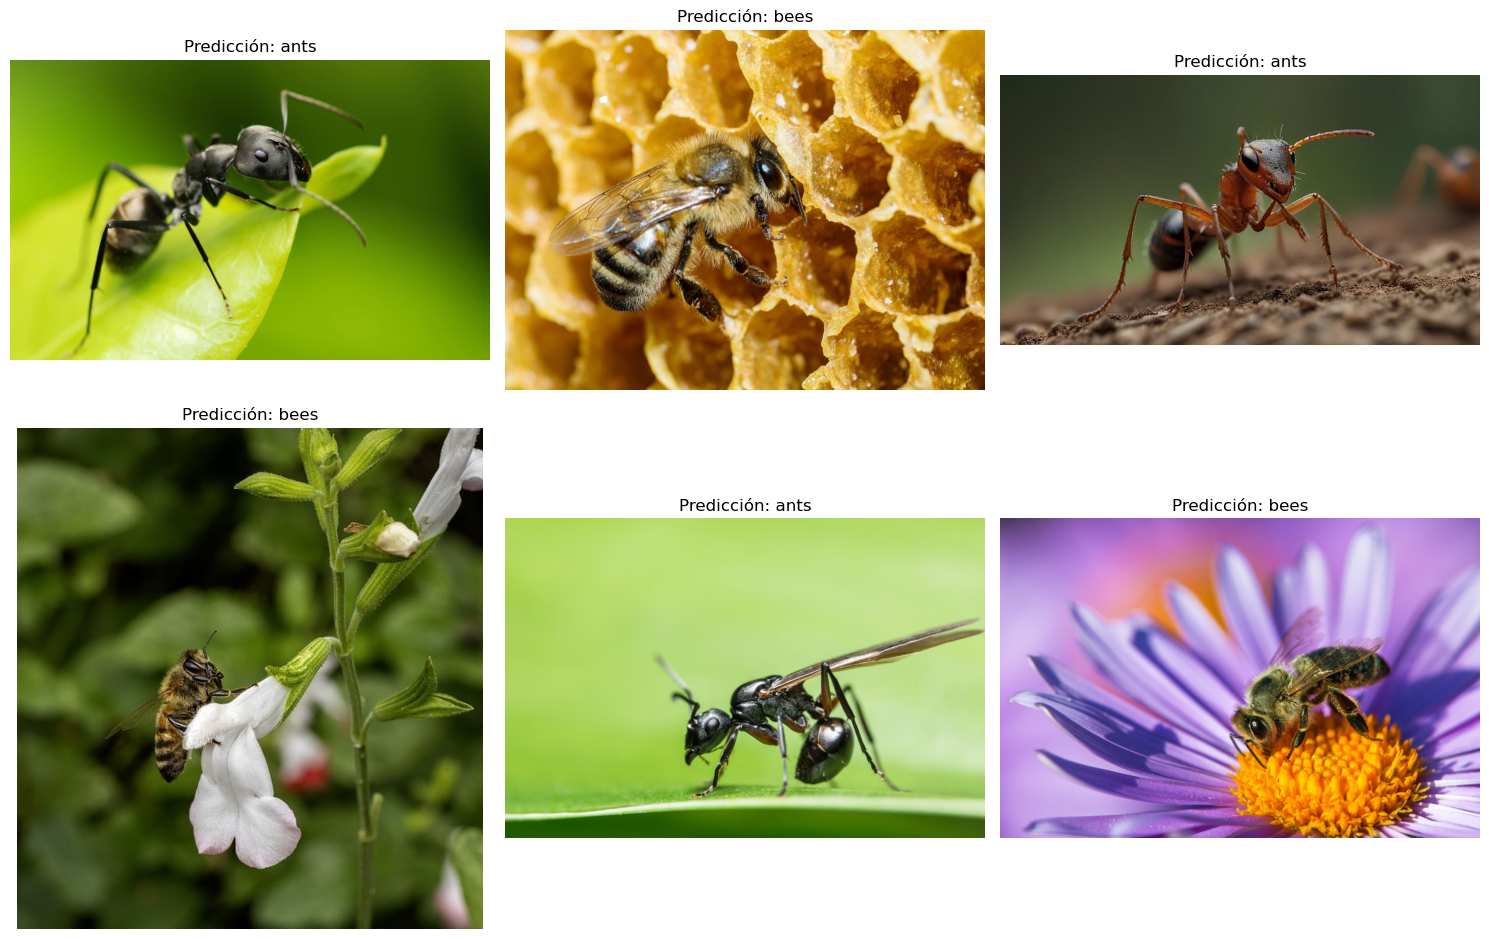

In [57]:

# Ruta a la carpeta que contiene las imágenes
folder_path = 'examples'

# Obtener una lista de todas las imágenes en la carpeta
image_files = [f for f in os.listdir(folder_path) if f.endswith(('.jpg', '.jpeg', '.png'))]

# Número de imágenes
num_images = len(image_files)

# Calcular el número de filas y columnas para el mosaico
cols = 3  # Puedes ajustar esto para tener más o menos columnas
rows = math.ceil(num_images / cols)

# Crear una figura con subplots
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))

# Aplanar los ejes para iterar fácilmente si hay más de una fila
axes = axes.flatten()

# Iterar sobre las imágenes y mostrarlas en el mosaico
for i, filename in enumerate(image_files):
    image_path = os.path.join(folder_path, filename)
    
    # Hacer la predicción
    prediction = predict_image(image_path)
    
    # Abrir la imagen
    image = Image.open(image_path)
    
    # Mostrar la imagen junto con la predicción
    axes[i].imshow(image)
    axes[i].set_title(f'Predicción: {prediction}')
    axes[i].axis('off')

# Eliminar los ejes sobrantes si hay menos imágenes que subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()